# Laboratory work #2

Import all significant libraries for this project.

In [1]:
# Import scikit-learn libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin, classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


# Import keras function for loading image
from keras.utils.image_utils import load_img

# Import libraries for text cleaning
import re
import string
import nltk
from nltk.corpus import stopwords
# Import WorldCloud class for visualisation
from wordcloud import WordCloud

# Import other libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
import itertools

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Who\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Downloading Dataset
Our dataset is Possible Asteroid Impacts with Earth (from [kaggle](https://www.kaggle.com/datasets/nasa/asteroid-impacts))

# Exercise #1

## Preprocessing Dataset

In [3]:
# Loading dataset to pandas DataFrame
asteroid_df = pd.read_csv("datasets\\asteroid_dataset\\asteroid_classification.csv")

In [4]:
# Drop unnecessary columns for analysis from the dataframe
asteroid_df.drop(["Object Name", "Epoch (TDB)", "Perihelion Argument (deg)", "Node Longitude (deg)",
                  "Mean Anomoly (deg)", "Perihelion Distance (AU)", "Aphelion Distance (AU)",
                  "Minimum Orbit Intersection Distance (AU)", "Orbital Reference"], axis=1, inplace=True)
print(asteroid_df.columns)

Index(['Object Classification', 'Orbit Axis (AU)', 'Orbit Eccentricity',
       'Orbit Inclination (deg)', 'Orbital Period (yr)', 'Asteroid Magnitude'],
      dtype='object')


In [5]:
# Drop null values of dataframe as we have only one null value
asteroid_df.dropna(inplace=True)
asteroid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15634 entries, 0 to 15634
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Object Classification    15634 non-null  object 
 1   Orbit Axis (AU)          15634 non-null  float64
 2   Orbit Eccentricity       15634 non-null  float64
 3   Orbit Inclination (deg)  15634 non-null  float64
 4   Orbital Period (yr)      15634 non-null  float64
 5   Asteroid Magnitude       15634 non-null  float64
dtypes: float64(5), object(1)
memory usage: 855.0+ KB


In [6]:
# Drop the 90% of data in dataframe
asteroid_df_size = asteroid_df.size
asteroid_df = asteroid_df[:int(asteroid_df_size*0.5)]

In [7]:
# Change class names
asteroid_df["Object Classification"].mask(asteroid_df["Object Classification"] == "Apollo Asteroid" ,
                                          "Apollo", inplace=True)
asteroid_df["Object Classification"].mask(asteroid_df["Object Classification"] == "Aten Asteroid",
                                          "Aten", inplace=True)
asteroid_df["Object Classification"].mask(asteroid_df["Object Classification"] == "Amor Asteroid",
                                          "Amor", inplace=True)
asteroid_df["Object Classification"].mask(asteroid_df["Object Classification"] == "Apohele Asteroid",
                                          "Apohele", inplace=True)
# Drop unnecessary class
necessary_class = ["Apollo", "Aten", "Amor"]
asteroid_df = asteroid_df[asteroid_df["Object Classification"].isin(necessary_class)]

In [8]:
def remove_outliers(dataframe, features):
    """Function to remove the outliers;
    :param dataframe: pandas DataFrame with data;
    :param features: list with features from dataframe.
    """
    # Copy dataframe to another variable
    dataframe_copy = dataframe.copy()

    # Iterate through features
    for feature in features:
        if dataframe[feature].dtype == object:
            continue
        # Calculate q1, q3 and iqr
        q3 = dataframe[feature].quantile(0.75)
        q1 = dataframe[feature].quantile(0.25)
        iqr = q3 - q1

        # Get local minimum and maximum
        local_min = q1 - (1.5 * iqr)
        local_max = q3 + (1.5 * iqr)

        # Remove the outliers
        dataframe_copy = dataframe_copy[(dataframe_copy[feature] >= local_min) &
                                        (dataframe_copy[feature] <= local_max)]

    return dataframe_copy

In [9]:
# Extract features from the df
asteroid_features = asteroid_df.columns.tolist()
print(asteroid_features)

['Object Classification', 'Orbit Axis (AU)', 'Orbit Eccentricity', 'Orbit Inclination (deg)', 'Orbital Period (yr)', 'Asteroid Magnitude']


In [10]:
# Remove outliers from the dataframe
asteroid_df = remove_outliers(asteroid_df, asteroid_features)

In [11]:
# View count of class names
print(asteroid_df.iloc[:, 0].value_counts())

Apollo    6651
Amor      5686
Aten       965
Name: Object Classification, dtype: int64


## Define Help Function for Visualisation

In [12]:
def pca_visualiser(x_var, y_var, n_components=2):
    """"""

    # Set PCA class object with n_components=2 (this will reduce the dimension to two)
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(x_var)

    pca_result_df = pd.DataFrame({'pca_1': pca_result[:, 0], 'pca_2': pca_result[:, 1], 'label': y_var})
    # View result on plot
    fig, ax = plt.subplots(1)
    sns.scatterplot(x='pca_1', y='pca_2', hue='label', data=pca_result_df, ax=ax, s=10)
    limit = (pca_result.min()-5, pca_result.max()+5)
    ax.set_xlim(limit)
    ax.set_ylim(limit)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.show()


def tsne_visualiser(x_var, y_var, n_components=2):
    """"""
    # Set TSNE class object with n_components=2 (this will reduce the dimension to two)
    tsne = TSNE(n_components=n_components)
    tsne_result = tsne.fit_transform(x_var)

    tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:, 0], 'tsne_2': tsne_result[:, 1], 'label': y_var})
    # View result on plot
    fig, ax = plt.subplots(1)
    sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax, s=10)
    limit = (tsne_result.min()-5, tsne_result.max()+5)
    ax.set_xlim(limit)
    ax.set_ylim(limit)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.show()


## Preprocess Dataset for PCA & TSNE

### Normalizing Dataset

In [13]:
# Normalise dataset
norm_asteroid_df = asteroid_df.copy()
# apply normalization techniques
for column in norm_asteroid_df:
    if norm_asteroid_df[column].dtype == object:
        continue
    norm_asteroid_df[column] = norm_asteroid_df[column] / norm_asteroid_df[column].abs().max()
# View normalised dataset
print(norm_asteroid_df.head())

  Object Classification  Orbit Axis (AU)  Orbit Eccentricity  \
1                  Amor         0.807646            0.590282   
2                  Amor         0.758732            0.610967   
4                  Amor         0.587438            0.469295   
8                  Amor         0.570204            0.427279   
9                Apollo         0.418531            0.469619   

   Orbit Inclination (deg)  Orbital Period (yr)  Asteroid Magnitude  
1                 0.296677             0.727119            0.492063  
2                 0.239656             0.661017            0.425397  
4                 0.304293             0.450847            0.561905  
8                 0.216477             0.430508            0.419048  
9                 0.240286             0.271186            0.451746  


### Numerizing Dataset

In [14]:
# Edit name of column "Object Classification" with _
# For using this name in next cell
number_asteroid_df = norm_asteroid_df.copy()
number_asteroid_df.rename(columns={"Object Classification": "Object_Classification"}, inplace=True)
# Replace string class to numbers
obj_class = {"Apollo": 0, "Aten": 1, "Amor": 2}
number_asteroid_df.Object_Classification = [obj_class[item] for item in number_asteroid_df.Object_Classification]
# View new dataset
print(number_asteroid_df.head())

   Object_Classification  Orbit Axis (AU)  Orbit Eccentricity  \
1                      2         0.807646            0.590282   
2                      2         0.758732            0.610967   
4                      2         0.587438            0.469295   
8                      2         0.570204            0.427279   
9                      0         0.418531            0.469619   

   Orbit Inclination (deg)  Orbital Period (yr)  Asteroid Magnitude  
1                 0.296677             0.727119            0.492063  
2                 0.239656             0.661017            0.425397  
4                 0.304293             0.450847            0.561905  
8                 0.216477             0.430508            0.419048  
9                 0.240286             0.271186            0.451746  


### Split Dataset to x & y

In [15]:
# Split Categorical Data
catg_x = asteroid_df.drop(["Object Classification"], axis=1)
catg_y = asteroid_df["Object Classification"]

In [16]:
# Split Normalised Dataset
norm_x = norm_asteroid_df.drop(["Object Classification"], axis=1)
norm_y = norm_asteroid_df["Object Classification"]

In [17]:
# Split Numeric Dataset
num_x = number_asteroid_df.drop(["Object_Classification"], axis=1)
num_y = number_asteroid_df["Object_Classification"]

## Use PCA (Principal Component Analysis)

### Set scaller for PCA

In [18]:
# Set scaler and train on catg_x var
scaler = StandardScaler()
catg_x_std = scaler.fit_transform(catg_x)

In [19]:
# Set scaler and train on norm_x var
scaler = StandardScaler()
norm_x_std = scaler.fit_transform(norm_x)

In [20]:
# Set scaler and train on num_x var
scaler = StandardScaler()
num_x_std = scaler.fit_transform(num_x)

### Define PCA class object for fitting

In [21]:
# Set PCA class object and train on X_std var
catg_pca = PCA()
catg_x_pca = catg_pca.fit_transform(catg_x_std)

In [22]:
# Set PCA class object and train on X_std var
norm_pca = PCA()
norm_x_pca = norm_pca.fit_transform(norm_x_std)

In [23]:
# Set PCA class object and train on X_std var
num_pca = PCA()
num_x_pca = num_pca.fit_transform(num_x_std)

### Visualise results

#### Visualise PCA (explained variance ratio)

In [24]:
# Set explained variance ration and cumulative sum for categorical PCA
catg_exp_var_pca = catg_pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(catg_exp_var_pca)

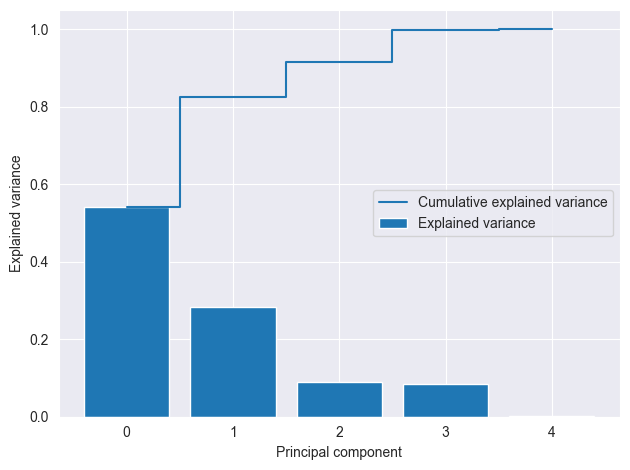

In [25]:
# View explained variance ration and cumulative sum on plot
plt.bar(range(0, len(catg_exp_var_pca)), catg_exp_var_pca, align='center', label="Explained variance")
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid', label="Cumulative explained variance")
plt.ylabel("Explained variance")
plt.xlabel("Principal component")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#### Visualise PCA

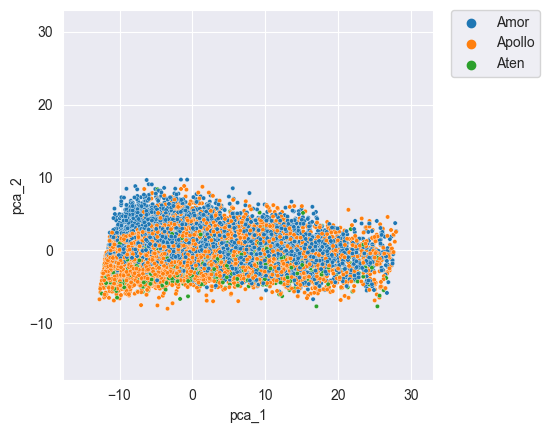

In [26]:
# Visualise for Categorical Data with n_components=2
pca_visualiser(catg_x, catg_y)

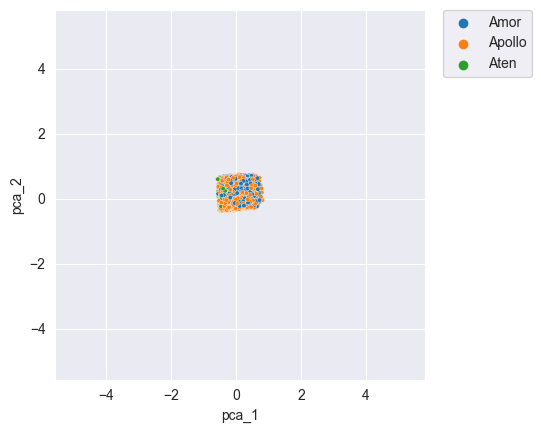

In [27]:
# Visualise for Normalised Data with n_components=2
pca_visualiser(norm_x, norm_y)

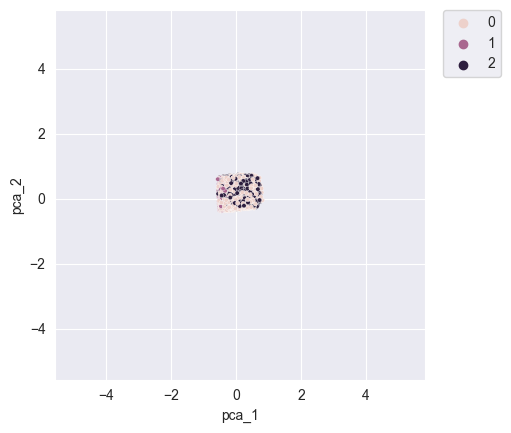

In [28]:
# Visualise for Numeric Data with n_components=2
pca_visualiser(num_x, num_y)

## Use TSNE (T-distributed Stochastic Neighbor Embedding)

D:\.main\.code\data_analysis_labs\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\.main\.code\data_analysis_labs\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


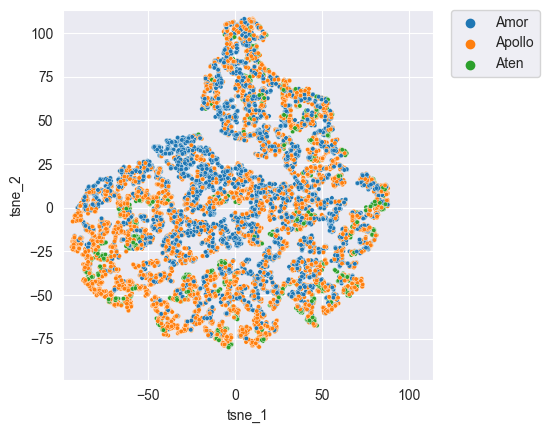

In [29]:
# Visualise for Categorical Data with n_components=2
tsne_visualiser(catg_x, catg_y)

D:\.main\.code\data_analysis_labs\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\.main\.code\data_analysis_labs\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


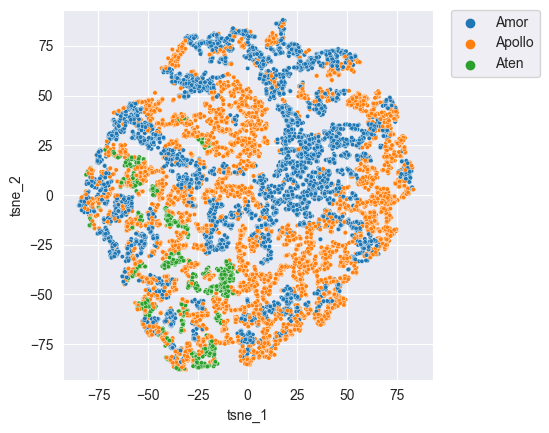

In [30]:
# Visualise for Normalised Data with n_components=2
tsne_visualiser(norm_x, norm_y)

D:\.main\.code\data_analysis_labs\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\.main\.code\data_analysis_labs\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


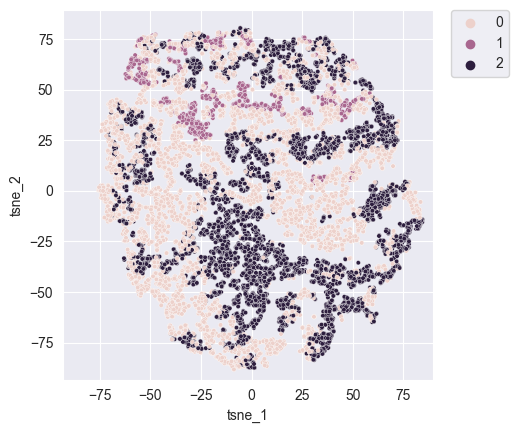

In [31]:
# Visualise for Numeric Data with n_components=2
tsne_visualiser(num_x, num_y)

# Exercise #2
Cluster analysis (image quantisation)

## Prepare function for analysis

In [32]:
def image_quantisation(image_array, rand_state, color_depth=64, n_samples=1000):
    """
    Function for quantise image;
    :param image_array: array with pixel data of image;
    :param rand_state: random state for getting the same result every time;
    :param color_depth: number of colours which will contain an image;
    :param n_samples: number of samples for shuffling the image_array.
    :return: kmeans - KMeans model for quantisation;
             labels - labels that predict kmeans model for image_array.
    """
    # Fitting model on small sub-sample with KMeans
    print("Fitting model on a small sub-sample of the data")
    t0 = time()
    image_array_sample = shuffle(image_array, random_state=rand_state, n_samples=n_samples)
    kmeans = KMeans(n_clusters=color_depth, random_state=rand_state).fit(image_array_sample)
    print(f"Done in {time() - t0:0.3f}s.")

    # Get labels for all points
    print("Predicting color indices on the full image (k-means)")
    t0 = time()
    labels = kmeans.predict(image_array)
    print(f"Done in {time() - t0:0.3f}s.")

    return kmeans, labels


def recreate_image(codebook, labels, width, height):
    """
    Function for recreating quantised image with kmean model "codebook" and labels which
    have been predicted, with same shape as original image;
    :param codebook: array which contain pixel value for quantised image with concrete colour depth;
    :param labels: labels array that contain label for distinguish needed pixel for codebook;
    :param width: width of image;
    :param height: height of image.
    :return: return recreated image.
    """
    return codebook[labels].reshape(width, height, -1)


def visualise_quantisation(model, labels, color_depth, width, height):
    """
    Help function for view result for quantisation;
    :param model: fitted kmeans model;
    :param labels: array of labels for recreating image;
    :param color_depth: colour depth which contains in the image;
    :param width: width of image;
    :param height: height of image.
    """
    plt.figure()
    plt.clf()
    plt.axis("off")
    plt.title(f"Quantised image ({color_depth} colors, K-Means)")
    plt.imshow(recreate_image(model.cluster_centers_, labels, width, height))

## Preprocessing Dataset

In [33]:
# Set random state
rand_state = 17
# Load the photo
image_path = "datasets\\amazon_books_reviews\\skyscraper.png"
skyscraper = load_img(image_path)

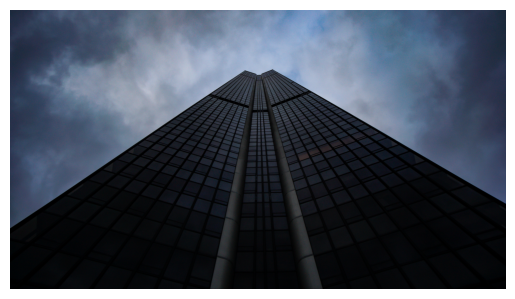

In [34]:
# View image
plt.imshow(skyscraper)
plt.axis("off")
plt.show()

In [35]:
# Convert data type of image to float64 and normalize image with dividing by 255
skyscraper = np.array(skyscraper, dtype=np.float64) / 255

In [36]:
# Load image and transform to a 2D numpy array
width, height, color = original_shape = tuple(skyscraper.shape)
assert color == 3
image_array = np.reshape(skyscraper, (width*height, color))

## Fitting model

In [37]:
## Fitting model with 64 colour depth
# Set colour depth
color_depth_64 = 64
# Quantise image
model_64, labels_64 = image_quantisation(image_array, rand_state, color_depth_64)

Fitting model on a small sub-sample of the data
Done in 0.897s.
Predicting color indices on the full image (k-means)
Done in 0.807s.


In [38]:
## Fitting model with 64 colour depth
# Set colour depth
color_depth_32 = 32
# Quantise image
model_32, labels_32 = image_quantisation(image_array, rand_state, color_depth_32)

Fitting model on a small sub-sample of the data
Done in 0.524s.
Predicting color indices on the full image (k-means)
Done in 0.527s.


In [39]:
## Fitting model with 64 colour depth
# Set colour depth
color_depth_16 = 16
# Quantise image
model_16, labels_16 = image_quantisation(image_array, rand_state, color_depth_16)

Fitting model on a small sub-sample of the data
Done in 0.462s.
Predicting color indices on the full image (k-means)
Done in 0.354s.


In [40]:
## Fitting model with 64 colour depth
# Set colour depth
color_depth_8 = 8
# Quantise image
model_8, labels_8 = image_quantisation(image_array, rand_state, color_depth_8)

Fitting model on a small sub-sample of the data
Done in 0.432s.
Predicting color indices on the full image (k-means)
Done in 0.319s.


## Visualise result

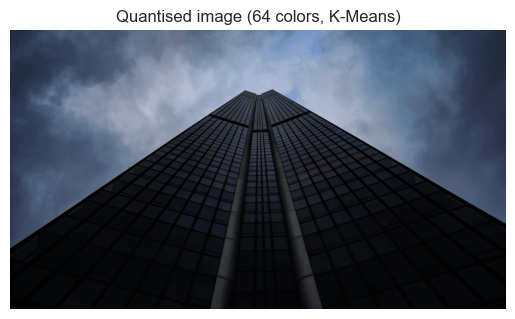

In [41]:
## Visualise for 64 colour depth
visualise_quantisation(model_64, labels_64, color_depth_64, width, height)

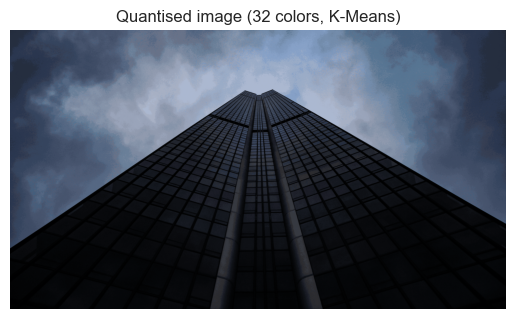

In [42]:
## Visualise for 32 colour depth
visualise_quantisation(model_32, labels_32, color_depth_32, width, height)

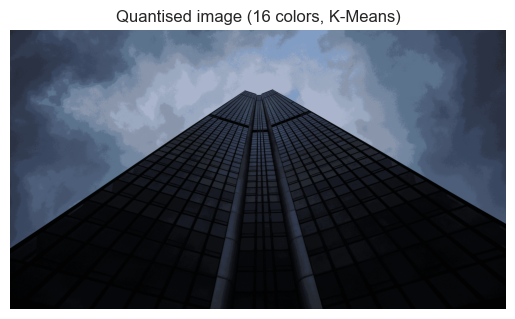

In [43]:
## Visualise for 16 colour depth
visualise_quantisation(model_16, labels_16, color_depth_16, width, height)

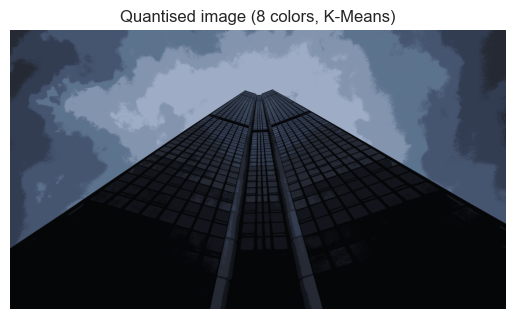

In [44]:
## Visualise for 8 colour depth
visualise_quantisation(model_8, labels_8, color_depth_8, width, height)

# Exercise #3

#### Downloading Dataset
Our dataset is Emotion Detection from Text (from [kaggle](https://www.kaggle.com/datasets/pashupatigupta/emotion-detection-from-text?resource=download))

## Preprocessing Dataset

In [45]:
# Load dataset
tweet_emotions = pd.read_csv("datasets\\emotion_detection_text\\tweet_emotions.csv")

In [46]:
# Drop NA values
tweet_emotions.dropna(inplace=True)
tweet_emotions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [47]:
# View dataset
tweet_emotions.head()

tweet_id   sentiment                                            content
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696     sadness                Funeral ceremony...gloomy friday...
3  1956967789  enthusiasm               wants to hang out with friends SOON!
4  1956968416     neutral  @dannycastillo We want to trade with someone w...

In [48]:
# View dataset columns
tweet_emotions.keys()

Index(['tweet_id', 'sentiment', 'content'], dtype='object')

In [49]:
# Drop unnecessary columns
tweet_emotions.drop(["tweet_id"], axis=1, inplace=True)

In [50]:
# View columns again
tweet_emotions.columns

Index(['sentiment', 'content'], dtype='object')

In [51]:
# View number of classes
set(tweet_emotions["sentiment"])

{'anger',
 'boredom',
 'empty',
 'enthusiasm',
 'fun',
 'happiness',
 'hate',
 'love',
 'neutral',
 'relief',
 'sadness',
 'surprise',
 'worry'}

In [52]:
# Leave only 3 classes
list_of_class = ["happiness", "sadness", "love"]
tweet_emotions = tweet_emotions.loc[tweet_emotions["sentiment"].isin(list_of_class)]

In [53]:
# View dataset classes
set(tweet_emotions["sentiment"])

{'happiness', 'love', 'sadness'}

In [54]:
# View info about dataset
tweet_emotions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14216 entries, 1 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  14216 non-null  object
 1   content    14216 non-null  object
dtypes: object(2)
memory usage: 333.2+ KB


In [55]:
# View new dataset
tweet_emotions.head()

sentiment                                            content
1   sadness  Layin n bed with a headache  ughhhh...waitin o...
2   sadness                Funeral ceremony...gloomy friday...
6   sadness  I should be sleep, but im not! thinking about ...
8   sadness            @charviray Charlene my love. I miss you
9   sadness         @kelcouch I'm sorry  at least it's Friday?

In [56]:
def clean_text(text_series):
    """
    Help function for cleaning dataset;
    :param text_series: pandas Series with string text data;
    :return: pandas Series with some changes in string cell.
    """
    # Set stopwords
    stop_words = stopwords.words("english")
    # Make cleaning
    text_series = text_series.str.lower()
    text_series = text_series.str.replace(r"@\S+", "")
    text_series = text_series.str.replace(r"https*\S+", "")
    text_series = text_series.str.replace(r"#\S+", "")
    text_series = text_series.str.replace(r"\d", "")
    text_series = text_series.str.replace(r"[%s]" % re.escape(string.punctuation), "")  # remove punctuations
    text_series = text_series.str.replace(r"\n", "")
    text_series = text_series.str.replace(r"\s{2,}", " ")
    # Remove Stop Words
    pat = r"\b(?:{})\b".format('|'.join(stop_words))
    text_series = text_series.str.replace(pat, "")
    text_series = text_series.str.replace(r"\s+", " ")

    return text_series

In [57]:
# Cleaning Dataset
tweet_emotions_cleaning = tweet_emotions.copy()
tweet_emotions_cleaning["content"] = clean_text(tweet_emotions_cleaning["content"])

C:\Users\Who\AppData\Local\Temp\ipykernel_9496\1908173840.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  text_series = text_series.str.replace(r"@\S+", "")
C:\Users\Who\AppData\Local\Temp\ipykernel_9496\1908173840.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  text_series = text_series.str.replace(r"https*\S+", "")
C:\Users\Who\AppData\Local\Temp\ipykernel_9496\1908173840.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  text_series = text_series.str.replace(r"#\S+", "")
C:\Users\Who\AppData\Local\Temp\ipykernel_9496\1908173840.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  text_series = text_series.str.replace(r"\d", "")
C:\Users\Who\AppData\Local\Temp\ipykernel_9496\1908173840.py:15: FutureWarning: The default value of regex will change from True to False in a future

In [58]:
# View clean dataset
tweet_emotions_cleaning.head()

sentiment                                            content
1   sadness             layin n bed headache ughhhhwaitin call
2   sadness                      funeral ceremonygloomy friday
6   sadness   sleep im thinking old friend want hes married...
8   sadness                                charlene love miss 
9   sadness                              im sorry least friday

## Visualise Dataset (Wordcloud)

In [59]:
# Define dataframe of classes
happiness = tweet_emotions_cleaning.loc[tweet_emotions_cleaning["sentiment"] == "happiness"]
love = tweet_emotions_cleaning.loc[tweet_emotions_cleaning["sentiment"] == "love"]
sadness = tweet_emotions_cleaning.loc[tweet_emotions_cleaning["sentiment"] == "sadness"]

In [60]:
# Define wordcloud object for happiness
stop_words = stopwords.words("english")
text = " ".join(i for i in happiness.content)
word_cloud = WordCloud(stopwords=stop_words, background_color="black").generate(text)

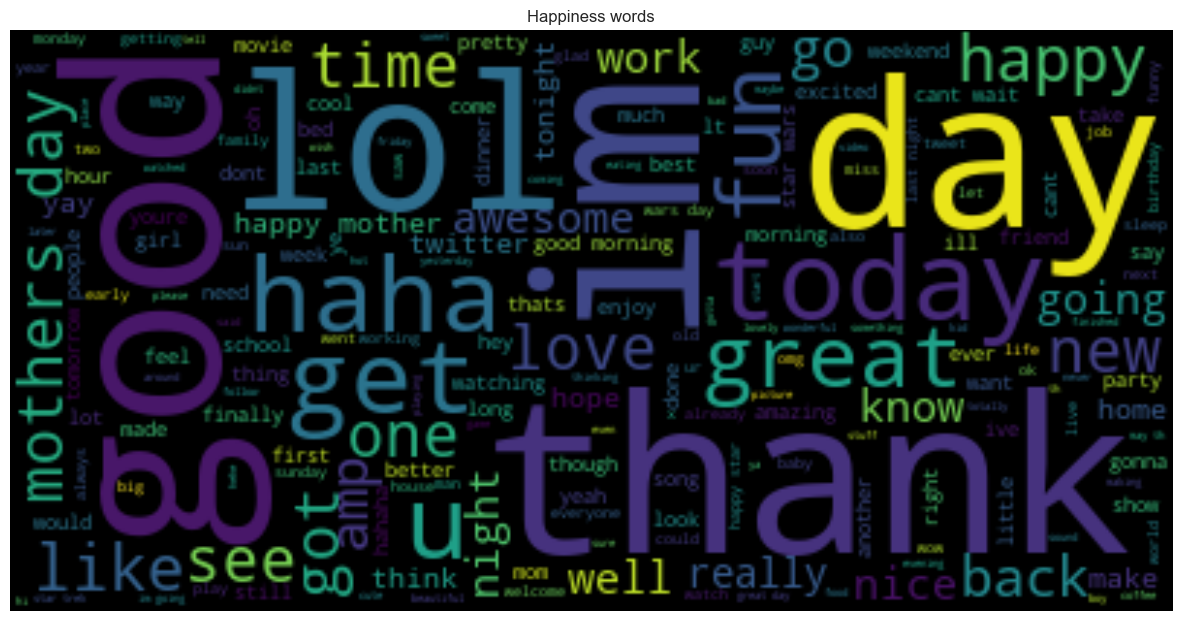

In [61]:
# Visualize wordcloud
plt.figure(figsize=(15, 10))
plt.imshow(word_cloud, interpolation="bilinear")
plt.title("Happiness words")
plt.axis("off")
plt.show()

In [62]:
# Define wordcloud object for love
stop_words = stopwords.words("english")
text = " ".join(i for i in love.content)
word_cloud = WordCloud(stopwords=stop_words, background_color="black").generate(text)

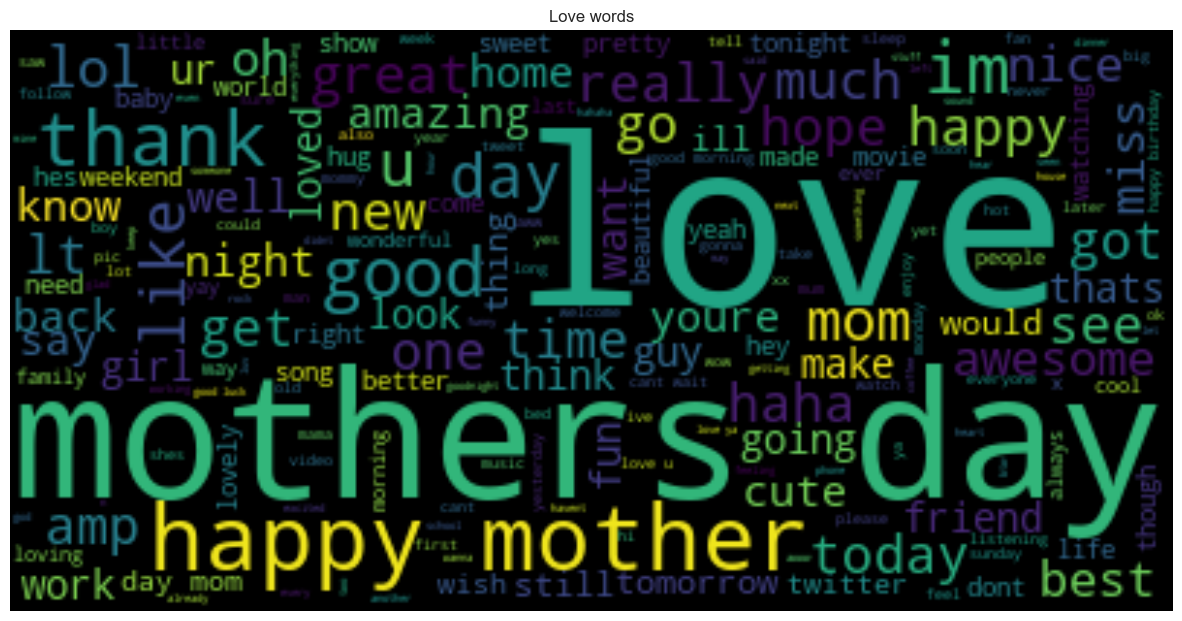

In [63]:
# Visualize wordcloud
plt.figure(figsize=(15, 10))
plt.imshow(word_cloud, interpolation="bilinear")
plt.title("Love words")
plt.axis("off")
plt.show()

In [64]:
# Define wordcloud object for sadness
stop_words = stopwords.words("english")
text = " ".join(i for i in sadness.content)
word_cloud = WordCloud(stopwords=stop_words, background_color="black").generate(text)

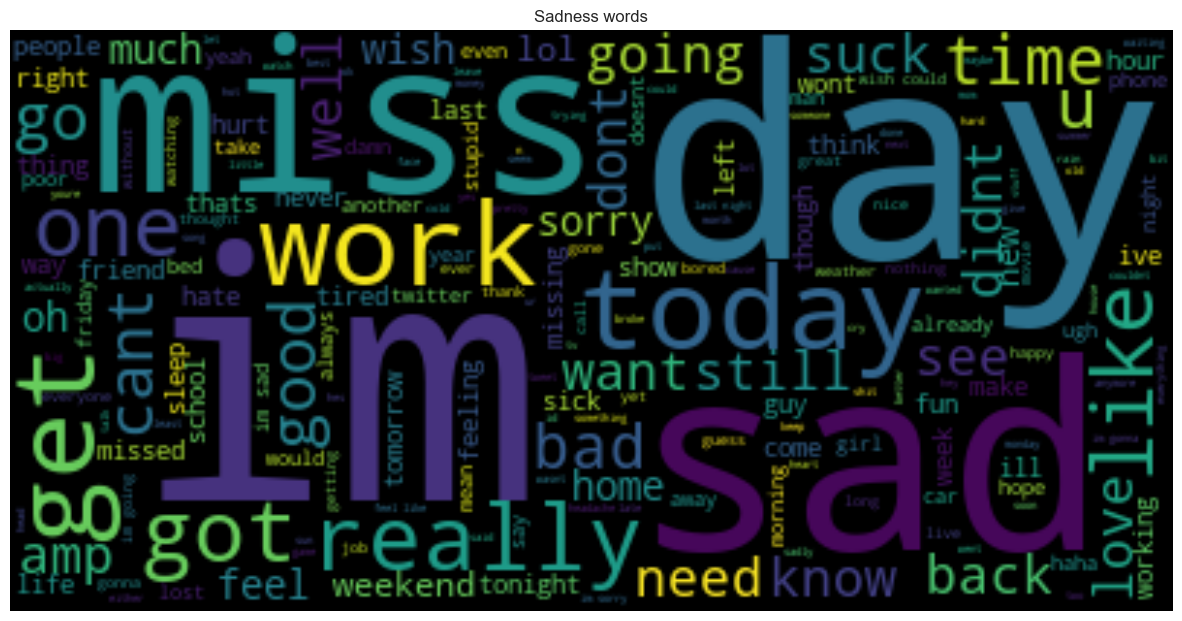

In [65]:
# Visualize wordcloud
plt.figure(figsize=(15, 10))
plt.imshow(word_cloud, interpolation="bilinear")
plt.title("Sadness words")
plt.axis("off")
plt.show()

## Make classification of text data
### (make assessment of quality)

In [66]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    """Makes a labelled confusion matrix comparing predictions and ground truth labels.

    If classes is passed, confusion matrix will be labelled, if not, integer class values
    will be used;
    :param y_true: Array of truth labels (must be same shape as y_pred);
    :param y_pred: Array of predicted labels (must be same shape as y_true);
    :param classes: Array of class labels (e.g. string form). If `None`, integer labels are used;
    :param figsize: Size of output figure (default=(10, 10));
    :param text_size: Size of output figure text (default=15);
    :param norm: normalize values or not (default=False);
    :param savefig: save confusion matrix to file (default=False).

    :returns: A labelled confusion matrix plot comparing y_true and y_pred.

    Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
    """
    # Create the confusion matrix
    confusion_mx = confusion_matrix(y_true, y_pred)
    confusion_mx_norm = confusion_mx.astype("float") / confusion_mx.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = confusion_mx.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(confusion_mx, cmap=plt.cm.Greens) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(confusion_mx.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will label with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (confusion_mx.max() + confusion_mx.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(confusion_mx.shape[0]), range(confusion_mx.shape[1])):
        if norm:
            plt.text(j, i, f"{confusion_mx[i, j]} ({confusion_mx_norm[i, j]*100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if confusion_mx[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{confusion_mx[i, j]}",
                     horizontalalignment="center",
                     color="white" if confusion_mx[i, j] > threshold else "black",
                     size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


def classification_confusion_evaluation(y_true, y_pred, classes=None):
    """
    Help function for viewing classification report of predictions and visualise confusion matrix;
    :param y_true: Array of truth labels (must be same shape as y_pred);
    :param y_pred: Array of predicted labels (must be same shape as y_true);
    :param classes: Array of class labels (as string).
    """
    model_accuracy = accuracy_score(y_true, y_pred)

    print("==>Classification Report<==")
    print(classification_report(y_true, y_pred))
    print("==>Confusion Matrix<==")
    make_confusion_matrix(y_true, y_pred, classes)
    print("==========================")
    print("==>Model accuracy: {:.2f}".format(model_accuracy))

In [67]:
# Split dataset to x & y variables
x = tweet_emotions_cleaning["content"]
y = tweet_emotions_cleaning["sentiment"]

In [68]:
# Split dataset to train & test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [69]:
# Define Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=500, min_df=10)

tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [70]:
# Fit Logistic Regression model
logistic_regression_model = LogisticRegression().fit(tfidf_train, y_train)

In [71]:
# Get prediction
y_pred = logistic_regression_model.predict(tfidf_test)

## Visualise result

==>Classification Report<==
              precision    recall  f1-score   support

   happiness       0.51      0.67      0.58       986
        love       0.51      0.31      0.38       810
     sadness       0.69      0.70      0.69      1048

    accuracy                           0.58      2844
   macro avg       0.57      0.56      0.55      2844
weighted avg       0.57      0.58      0.56      2844

==>Confusion Matrix<==
==>Model accuracy: 0.58


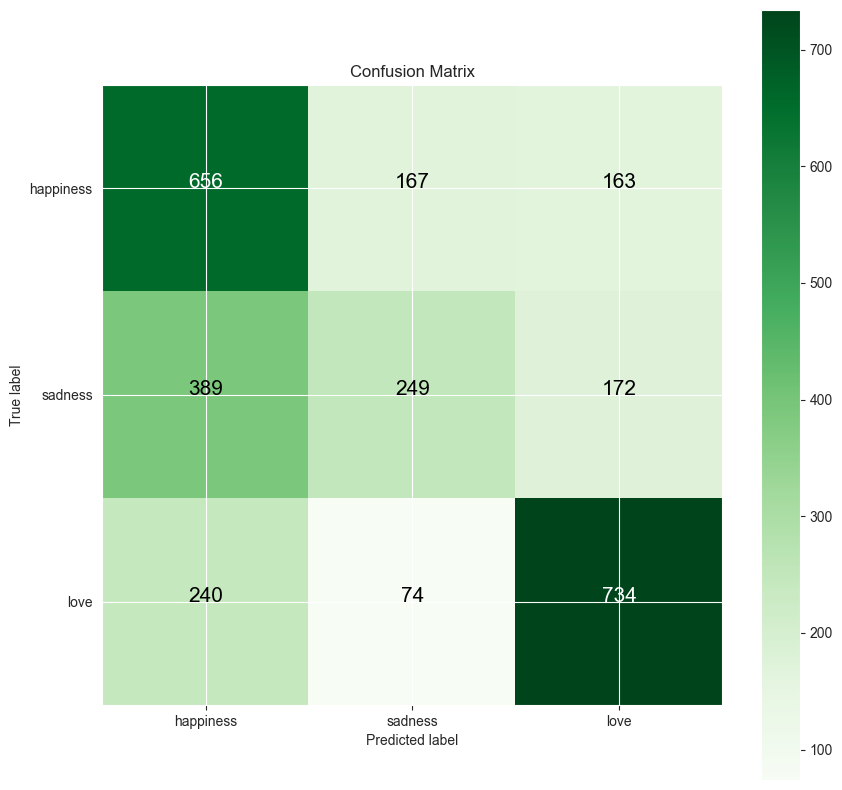

In [72]:
# View classification report and confusion matrix
classification_confusion_evaluation(y_test, y_pred, list_of_class)